In [1]:
import os
from collections import namedtuple
from dataclasses import dataclass

import numpy as np
from numba import jit, njit
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.stats import bootstrap
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution, NonlinearConstraint
from sympy import Symbol, MatrixSymbol, Matrix, ones, Eq, Identity

from sympy.matrices import hadamard_product as hadamard

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from IPython.display import display, Markdown

sns.set()
sns.set_style("white")
sns.set_style('ticks')

%matplotlib ipympl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.latex.preamble'] = r"\usepackage{lmodern}"

mm = 1/25.4 ## mm to inches conversion

In [2]:
#https://www.springer.com/gp/authors-editors/journal-author/journal-author-helpdesk/manuscript-preparation/1260#:~:text=When%20preparing%20your%20figures%2C%20size,not%20higher%20than%20198%20mm.

# When preparing your figures, size figures to fit in the column width.
# For most journals the figures should be 39 mm, 84 mm, 129 mm, or 174 mm wide and not higher than 234 mm.
# For books and book-sized journals, the figures should be 80 mm or 122 mm wide and not higher than 198 mm.

# System of ODEs

$$ \frac{dP_{j}}{dt} =  \big[P_{j}r_{j} + \sigma f \zeta (\gamma \odot \beta)^{\top}_{jk}P_{k} + I_{j}\big](1 - \frac{P_{j}}{K_{j}}) $$

where ($\odot$) is the Hadamard product (element by element multiplication). All variables besides $P$ are assumed constant in time.
The quantities $r$, the product ($\gamma \odot \beta$), and $I$, will be fit to a time series of $P(t)$ randomly generated from bootstrap-derived confidence intervals about field observations. Below we symbolically expand this system for two connected subpopulations - the backreef and forereef (subscripts ($_0$,$_1$) respectively).
<!-- $\oslash$ hadamard division -->

In [4]:
n = 2
f = Symbol('f')
𝜎 = Symbol('𝜎')
𝜁 = Symbol('𝜁')
P = Matrix( MatrixSymbol("P", n, 1) )
r = Matrix( MatrixSymbol("r", n, 1) )
K = Matrix( MatrixSymbol("K^-1", n, 1) )
I = Matrix( MatrixSymbol("I", n, 1) )
γ = Matrix( MatrixSymbol("γ", n, n) )
β = Matrix( MatrixSymbol("β", n, n) )

odes = hadamard( (hadamard(P,r) + 𝜎*f*𝜁*hadamard( γ, β ).T*P + I), ones(2,1) - hadamard(K,P) )
display( Eq(Symbol("P_{0}'"), odes[0].collect(P[0,0])) )
display( Eq(Symbol("P_{1}'"), odes[1].collect(P[1,0])) )

Eq(P_{0}', (-K^-1[0, 0]*P[0, 0] + 1)*(f*𝜁*𝜎*P[1, 0]*β[1, 0]*γ[1, 0] + (f*𝜁*𝜎*β[0, 0]*γ[0, 0] + r[0, 0])*P[0, 0] + I[0, 0]))

Eq(P_{1}', (-K^-1[1, 0]*P[1, 0] + 1)*(f*𝜁*𝜎*P[0, 0]*β[0, 1]*γ[0, 1] + (f*𝜁*𝜎*β[1, 1]*γ[1, 1] + r[1, 0])*P[1, 0] + I[1, 0]))

When fitting the ODE system above it is impossible to discern between the effects of $\beta$ (settlement probability) and $\gamma$ (planula transport fraction) without more information. We instead elect to fit their product $C =  (\gamma \odot \beta)$. The code implementation of numerically solving the two population system is shown below. 

In [5]:
@jit
def coral_ode(p, t, n, k, f, sigma, C, I, 𝜁 = 0.5):
    """System of ODE's to be solved"""
    #_numba_'s @jit decorator is used to optimize performance as this function will be called many times over the course of the optimization routine
    
    
    dp = np.zeros((n))
    
    for i in range(n):
        dp[i] = ( sigma*f*𝜁*np.dot( C[:,i], p) + I[i] )*(1 - p[i]/k[i]) 
        dp[i] += -sigma*f*𝜁*C[i,i]*p[i]*(1 - p[i]/k[i]) #only account for recruit/polyp for exchange terms 
        dp[i] += C[i,i]*p[i]*(1 - p[i]/k[i])  # on diagonal terms are total intrinsic growth

    return dp

## Constraints

The system will be subject to the following constraints...

_recruitment limiter_
$$ \zeta f \sigma (\gamma \odot \beta)_{jk} P_k + I_j < \rho_j $$

_planula conservation_
$$ 0 \leq \Sigma_{k} \gamma_{jk} \leq 1 $$
$$ 0 \leq \beta  \leq 1 $$ 

where $\rho_j$ is the upper bound on recruitment from field data. In our implementation, the recruitment limiter is not set dynamically with the population, which would be practically difficult. Instead, model fits that violate the constraint are simply ignored.

## Optimization

The Differential Evolution global optimization routine will be used to find sets of parameters that minimize the mean squared hindcast error between model estimates and Monte-Carlo simulations of coral cover. The objective function to be minimized is 

$$ J = A \frac{1}{n}\sum^{n}_{i=1}\big[\mathcal{F}_b(t_i) - p_b(t_i) \big]^{2} 
     + B \frac{1}{n}\sum^{n}_{i=1}\big[\mathcal{F}_f(t_i) - p_f(t_i) \big]^{2} $$
where $\mathcal{F}$ is the solution to the ODE system evaluated at the points in time $t_i$ where coral cover data are available. Subscripts $b$ and $t$ indicate backreef and forereef sites respectively, while ($A$,$B$) are weight coefficients.

# Import field data

In [311]:
#Forereef recruitment from photoquadrat
df_fr_recruit = pd.read_csv( "corals_small_fr.csv", header = 0).dropna()

#Backreef recruitment estimates from hilton site measurements 
df_br_recruit = pd.read_excel("corals_small_br.xlsx", header = 1).dropna()

df_fr = pd.read_csv("cover_forereef.csv", header = 0).dropna()
df_br = pd.read_csv("cover_backreef.csv", header = 0).dropna()

## Create custom class to hold information about the sites: LTER1, LTER2
- **area**: (m^2) 100 m wide rectangle from shore to the reef crest over which areas of hard bottom were quantified by outlining and area in Image J. Estimated in Google Earth
- **fraction**: viable area inhabitable by coral from 2018 total coverage quadrats (Pete Edmunds)
- **σ**: recruit size class (polyps/recruit). Assumes 4cm diameter circular recruits and 66 polyps/cm^2 (Holly Putnam)
- **k**: carrying capacity (polyps).  From multiplying total area by viable area fraction and polyp density 
- **fecundity**: (planula/polyp/yr). Takes average of Sier+Oliver 1994, Stimson 1976 (Holly Putnam)
- **cover**: observed mean pocillopora \% cover. 
- **tobs**: year of observation.

In [312]:
@dataclass
class CoralPopulation():

    polypdensity: float = 660000.0 #polyps/m^2
    recruitsize: float = np.pi*(0.04/2)**2 #m^2/recruit, assumes circular recruits 4cm diameter
    sigma: float = polypdensity*recruitsize #polyps/recruit 
    fecundity: float = 95.0 #fecundity planula/polyp/year: average of Sier+Oliver 1994, Stimson 1976
    maturation: float = 0.5 #larval maturation fraction (ζ)
    
    def __init__(self, n, area, fraction, cover, name = None):#, recruit_lim = None):
        self.name = name
        self.n = n #number of populations
        self.area = area #area in m^2
        self.fraction = fraction
        self.k = fraction*self.area*self.polypdensity #carrying capacity (# of polyps)
        self.f = self.fecundity*self.maturation #or np.array([self.fecundity]*self.n) 
        
        self.meancover = cover
        self.meanpolyps = cover*self.area*self.polypdensity
        self.tobs = cover.index.values
        self.tsim = np.linspace( self.tobs.min(), self.tobs.max(), 100) #calculation simulation time
        self.p0 = self.meanpolyps.iloc[0,:].values #initial population is first value of cover value for each population in time series
        
        self.bootci = {} #empty dictionary for bootstrap confidence intervals
        
    def polyp2cover(self, polyp, area):
        return polyp*100/self.polypdensity/area
    
    def cover2polyp(self, cover, area):
        return cover/100*self.polypdensity*area

### Initiate classes with field data

In [322]:
#LTER1
br = df_br.groupby(["Site","Year"])["Pocillopora % Cover"].mean()["LTER1"].rename("backreef", inplace = True)/199
fr = df_fr.groupby(["Site","Year"])["Pocillopora % Cover"].mean()["LTER1"].rename("forereef", inplace = True)/100
#df1 = pd.DataFrame(data=dict(forereef=fr, backreef=br), index=fr.index)#[::-1]
df1 = pd.DataFrame(data=dict(backreef=br, forereef=fr), index=fr.index)

#LTER2
br = df_br.groupby(["Site","Year"])["Pocillopora % Cover"].mean()["LTER2"].rename("backreef", inplace = True)/100
fr = df_fr.groupby(["Site","Year"])["Pocillopora % Cover"].mean()["LTER2"].rename("forereef", inplace = True)/100
df2 = pd.DataFrame(data=dict(forereef=fr, backreef=br), index=fr.index)

#Convert % to fractional cover ^^^

LTER1 = CoralPopulation(n = 2, area = [101*709, 101*243], fraction = np.array([.45, .803]), cover = df1, name = "lter1") 
LTER2 = CoralPopulation(n = 2, area = [101*706, 101*243], fraction = np.array([.49, .625]), cover = df2, name = "lter2") 

# Confidence intervals from data
1. Estimate confidence intervals on coral cover through bootstrapping
2. Exponential fits and 99% confidence intervals on recruitment data

To constrain the model and generate Monte-Carlo simulations, confidence intervals on coral cover and recruitment must be calculated

## Bootstrapped confidence intervals on coral cover

Here we using bootstrapping to construct 95% confidence intervals for the mean coral cover at the forereeef/backreef sites at LTER1/LTER2. 
Approximately 40 photoquadrats were used each year on the forereef, and five for backreef measurements.
Later, we will randomly draw samples within these intervals to construct model fits to the time series to estimate model fitting parameters.

In [323]:
def bootstrap_dataframe(arr):
    
    series = arr.apply(lambda x: bootstrap( (x["Pocillopora % Cover"].values,), statistic =  np.mean, n_resamples = 10e4, method = 'BCa') )
    
    dff = series.to_frame()
    dff.columns = ["bootstrap"]
    dff["lo"] =   dff["bootstrap"].apply(lambda x: x.confidence_interval[0])
    dff["hi"] =   dff["bootstrap"].apply(lambda x: x.confidence_interval[1])
    dff["mean"] = dff["bootstrap"].apply(lambda x: np.mean(x.bootstrap_distribution))
    dff.drop(columns = ["bootstrap"], inplace = True)
    
    return dff

LTER1.bootci["backreef"] = bootstrap_dataframe( df_br.loc[df_br["Site"] == "LTER1"].groupby(["Year"]) )
LTER1.bootci["forereef"] = bootstrap_dataframe( df_fr.loc[df_fr["Site"] == "LTER1"].groupby(["Year"]) )
LTER2.bootci["backreef"] = bootstrap_dataframe( df_br.loc[df_br["Site"] == "LTER2"].groupby(["Year"]) )
LTER2.bootci["forereef"] = bootstrap_dataframe( df_fr.loc[df_fr["Site"] == "LTER2"].groupby(["Year"]) )                         

## Bootstrap peak year recruitment



In [324]:
res_br = bootstrap( (df_br_recruit["Small colonies / 0.25 m^2"], ) , np.mean, n_resamples = 10e3, method = 'BCa')

fr1_recruits = df_fr_recruit.loc[df_fr_recruit["Year"] == 2014].loc[df_fr_recruit["Site"] == "LTER1"]["Small colonies / 0.25 m^2"]
fr2_recruits = df_fr_recruit.loc[df_fr_recruit["Year"] == 2014].loc[df_fr_recruit["Site"] == "LTER2"]["Small colonies / 0.25 m^2"]
res1 = bootstrap( (fr1_recruits,) , np.mean, n_resamples = 10e3, method = 'BCa')
res2 = bootstrap( (fr2_recruits,) , np.mean, n_resamples = 10e3, method = 'BCa')
                  
display(f"LTER FR 1 = {res1.confidence_interval}",
        f"LTER FR 2 = {res2.confidence_interval}",
        f"Backreef = {res_br.confidence_interval}")

'LTER FR 1 = ConfidenceInterval(low=3.236842105263158, high=9.150621910996627)'

'LTER FR 2 = ConfidenceInterval(low=4.025, high=5.85)'

'Backreef = ConfidenceInterval(low=0.39351193470167234, high=0.8682101033543334)'

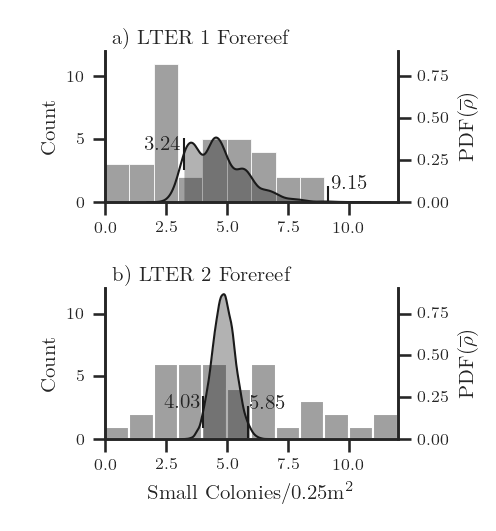

In [325]:
plt.close("all")
fig,ax = plt.subplots(2,1, sharex = False, figsize = (84*mm, 90*mm))

axy = ax[0].twinx()
sns.histplot(fr1_recruits.values, binwidth = 1,  kde = False, stat = "count", color = [0.5,0.5,0.5], ax = ax[0])
sns.kdeplot(res1.bootstrap_distribution, ax = axy, color = "k", linewidth = 1)

axy2 = ax[1].twinx()
sns.histplot(fr2_recruits.values, binwidth = 1,  kde = False, stat = "count", color = [0.5,0.5,0.5], ax = ax[1])
sns.kdeplot(res2.bootstrap_distribution, ax = axy2, color = "k", linewidth = 1)

ax[0].set_ylabel("Count", fontsize = 10)
ax[1].set_ylabel("Count", fontsize = 10)
axy.set_ylabel(r"$\mathrm{PDF}(\overline{\rho})$", fontsize = 10)
axy2.set_ylabel(r"$\mathrm{PDF}(\overline{\rho})$", fontsize = 10)

for axis, label in zip(ax,["a) LTER 1 Forereef","b) LTER 2 Forereef"]):
    axis.set_xlim(0,12)
    axis.set_ylim(0,12)
    axis.annotate( f"{label}", (0.025, 1.05), xycoords = "axes fraction", fontsize = 10)
    axis.tick_params(labelsize = 8)

axy.tick_params(labelsize = 8)
axy2.tick_params(labelsize = 8)


for axis, ci in zip( [axy,axy2], [res1,res2] ) :
    axis.set_ylim(0, 0.9)
    
    x,y = axis.get_lines()[0].get_data()
    condition = (x > ci.confidence_interval.low) & (x < ci.confidence_interval.high)
    axis.fill_between(x,y, where = condition, color = "k", alpha = 1/3, linewidth = 0.0)

    ylo =  y[np.argmin( abs(x - ci.confidence_interval.low))]
    yhi =  y[np.argmin( abs(x - ci.confidence_interval.high))]
    axis.plot(ci.confidence_interval.low,  ylo, '|', color = "k", markersize = 15 )
    axis.plot(ci.confidence_interval.high, yhi, '|', color = "k", markersize = 15 )
    
    axis.text(ci.confidence_interval.low - 0.1, ylo, f"{ci.confidence_interval.low:.2f}", horizontalalignment='right', verticalalignment='bottom', fontsize = 10)
    axis.text(ci.confidence_interval.high + 0.1, yhi + 0.05, f"{ci.confidence_interval.high:.2f}", verticalalignment='bottom', fontsize = 10)
        
ax[1].set_xlabel("Small Colonies/$0.25$m$^2$", fontsize = 10)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
axy.spines['top'].set_visible(False)
axy2.spines['top'].set_visible(False)

fig.tight_layout()
#fig.savefig("recruit.pdf")#, dpi = 300)

 # Global Optimization

We use the SciPy implementation of the differential evolution optimization routine to minimize the sum of squared error between the model fit and sampled data. The system of differential equations is solved using the Python implementation (_odeint_) of the _LSODA_ method.
 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html


## Which site?

Change LTER (1,2) here before running code below

In [326]:
lter = LTER1
res = res1

## Apply constraints

Notice that the constraints and fits are applied to $-C$ and $I$ exponentiated. This is partly for smoother optimization searches, but mostly because we consider getting the order of magnitude roughly close victory enough.

In [327]:
#only apply this constraint after R is predicted for maximum self recruitment. does not need to happen online during model?
#bounds on imimgration are sufficient

def constraint_planula_br(x):
    "planula conservation"
    return ( np.exp(-x[0]) + np.exp(-x[1]) )

def constraint_planula_fr(x):
    "planula conservation"
    return ( np.exp(-x[2]) + np.exp(-x[3]) )

#should be 3 terms each right? self, cross, immigration
def constraint_recruit_br(x):
    return ( (lter.sigma*lter.f)*( np.exp(-x[0])*lter.k[0] + np.exp(-x[1])*lter.k[1]) )

def constraint_recruit_fr(x):
    return ( (lter.sigma*lter.f)*( np.exp(-x[2])*lter.k[0] + np.exp(-x[3])*lter.k[1]) )

## Define objective function

note: the objective function is weighted slightly so that the backreef is not so brutally penalized for containing relatively low coral cover values.

In [328]:
def x2ci(x):
    """convert 1D optimization output back to matrix form for ODE solver"""
    C = np.asarray( np.reshape(x[:lter.n*lter.n], (lter.n,lter.n), order = "F") ) #exchange matrix
    C[0,1], C[1,0] = np.exp(-C[0,1]), np.exp(-C[1,0]) #only exponentiate cross-exchange terms - self recruitment is now growth rate
    I = np.exp( x[-lter.n:] ) #immigration
    return C,I

def SSE(x, lter, polyps_br, polyps_fr):
    """Function to be minimized: weighted sum of squared error from field observations"""
    C, I = x2ci(x)
    p0 = [polyps_br[0], polyps_fr[0]] #convert to polyps
    args =  (lter.n, lter.k, lter.f, lter.sigma, C, I)
    sol = odeint(coral_ode, y0 = p0,  t = lter.tsim, args = args ) #solve ODE
    Fb =  interp1d(lter.tsim, sol[:,0]) #interpolant
    Ff =  interp1d(lter.tsim, sol[:,1]) #interpolant
    
    pb = Fb(lter.tobs) #evaluate at observation times
    pf = Ff(lter.tobs) #evaluate at observation times
    #sse = 0.01*np.mean( ((pb - polyps_br)/polyps_br)**2 ) + np.mean( ((pf - polyps_fr)/polyps_fr)**2 ) #sse in terms of cover for better numerics
    sse = 100*np.mean( ((pb - polyps_br)/lter.k[0])**2 ) + np.mean( ((pf - polyps_fr)/lter.k[1])**2 ) #sse in terms of cover for better numerics
    return sse

def nmse(x, lter, polyps_br, polyps_fr):
    """Function to be minimized: mean r^2 at both sites"""
    
    C, I = x2ci(x)
    p0 = [polyps_br[0], polyps_fr[0]] #convert to polyps
    args =  (lter.n, lter.k, lter.f, lter.sigma, C, I)
    sol = odeint(coral_ode, y0 = p0,  t = lter.tsim, args = args ) 
    Fb =  interp1d(lter.tsim, sol[:,0]) #interpolant
    Ff =  interp1d(lter.tsim, sol[:,1]) #interpolant
    
    pb = Fb(lter.tobs) #evaluate at observation times
    pf = Ff(lter.tobs) #evaluate at observation times
    
    #Convert to cover for better numerics
    pb = lter.polyp2cover(pb, area = lter.area[0])
    pf = lter.polyp2cover(pf, area = lter.area[1])
    cover_br = lter.polyp2cover(polyps_br, area = lter.area[0])
    cover_fr = lter.polyp2cover(polyps_fr, area = lter.area[1])

    mse_br = np.sum( (cover_br - pb)**2 )/len(pb)
    mse_fr = np.sum( (cover_fr - pf)**2 )/len(pf)
    
    #normalized by standard deviation?
    norm_br = np.std(cover_br)
    norm_fr = np.std(cover_fr)
    
    #weighted mean betweent both sites
    nmse_weight = (0.1*mse_br/norm_br + 0.9*mse_fr/norm_fr)
    
    return nmse_weight

def R2(x, lter, polyps_br, polyps_fr):
    
    """Function to be minimized: mean r^2 at both sites"""
    C, I = x2ci(x)
    p0 = [polyps_br[0], polyps_fr[0]] #convert to polyps
    args =  (lter.n, lter.k, lter.f, lter.sigma, C, I)
    sol = odeint(coral_ode, y0 = p0,  t = lter.tsim, args = args ) #solve ODE
    Fb =  interp1d(lter.tsim, sol[:,0]) #interpolant
    Ff =  interp1d(lter.tsim, sol[:,1]) #interpolant
    
    pb = Fb(lter.tobs) #evaluate at observation times
    pf = Ff(lter.tobs) #evaluate at observation times
    
    pb = lter.polyp2cover(pb, area = lter.area[0])
    pf = lter.polyp2cover(pf, area = lter.area[1])
    cover_br = lter.polyp2cover(polyps_br, area = lter.area[0])
    cover_fr = lter.polyp2cover(polyps_fr, area = lter.area[1])
    
    ss_res_br = np.sum( (cover_br - pb)**2 ) 
    ss_res_fr = np.sum( (cover_fr - pf)**2 ) 
    ss_tot_br = np.sum( ( cover_br - np.mean(cover_br) )**2 ) 
    ss_tot_fr = np.sum( ( cover_fr - np.mean(cover_fr) )**2 ) 
    R2bar_weight = ( 0.1*abs(ss_res_br/ss_tot_br) + 0.9*abs(ss_res_fr/ss_tot_fr) )
    
    return R2bar_weight
    
#Use rho for bound on immigration?
# rho_fr = res.confidence_interval.high*4*lter.area[1]*lter.sigma
# rho_br = res.confidence_interval.high*4*lter.area[1]*lter.sigma

bounds = [ (-1,1), (0, 36), (0, 36), (0,1), ( 0, np.log(lter.k[0]) ), ( 0, np.log(lter.k[1]) ) ] #set bounds on parameters

## Model fit to mean cover demo

As a sanity check, we generate and plot the model hindcast for the mean coral cover data at LTER#

In [338]:
@jit
def coral_ode_dia(p, t, k, f, sigma, C, I, 𝜁 = 0.5):
    """System of ODE's to be solved"""
    #only multiply cross exchange terms - on diagonal terms are total intrinsic growth
    n = 2
    dp = np.zeros((2*n))
    
    #Endogeous
    for i in range(n):
        j = i + n
        cff = (1 - (p[i] + p[j])/k[i]) 
        dp[i] = ( sigma*f*𝜁*np.dot( C[:,i], p[:n] ) )*cff
        dp[i] += -sigma*f*𝜁*C[i,i]*p[i]*cff
        dp[i] += C[i,i]*p[i]*cff

    #Exogenous
    for j in range(n,2*n):
        i = j - n
        cff = (1 - (p[i] + p[j])/k[i]) 
        dp[j]  = ( sigma*f*𝜁*np.dot( C[:,i], p[n:] ) + I[i] )*cff
        dp[j] +=  -sigma*f*𝜁*C[i,i]*p[j]*cff
        dp[j] += C[i,i]*p[j]*cff
    
    return dp

In [339]:
def sol2df(sol, lter):

    df = pd.DataFrame(data = sol, index = lter.tsim, 
                      columns = ["Backreef Endogenous", 
                                 "Forereef Endogenous", 
                                 "Backreef Exogenous", 
                                 "Forereef Exogenous"]) 
    
    df["Backreef Endogenous"] = lter.polyp2cover( df["Backreef Endogenous"], lter.area[0] )
    df["Forereef Endogenous"] = lter.polyp2cover( df["Forereef Endogenous"], lter.area[1] )
    df["Backreef Exogenous"]  = lter.polyp2cover( df["Backreef Exogenous"],  lter.area[0] )
    df["Forereef Exogenous"]  = lter.polyp2cover( df["Forereef Exogenous"],  lter.area[1] )

    df["Backreef Total"]  = df["Backreef Endogenous"] + df["Backreef Exogenous"]
    df["Forereef Total"]  = df["Forereef Endogenous"] + df["Forereef Exogenous"]
    
    return df

In [340]:
m = differential_evolution(nmse, bounds = bounds, args = (lter, lter.meanpolyps["backreef"].values, lter.meanpolyps["forereef"].values,), 
                           disp = False, workers = 1, mutation = .75, recombination = 0.75, updating = "deferred")
C, I = x2ci(m.x)
#sol = odeint(coral_ode, lter.p0, lter.tsim, args = (lter.n, lter.k, lter.f, lter.sigma, C, I) )

p0 = np.append(lter.p0, (0,0))
args = tuple( [lter.k, lter.f, lter.sigma, C, I] )
sol = odeint(coral_ode_dia,  y0 = p0,  t = lter.tsim, args = args)
df = sol2df(sol, lter)

In [341]:
def dpdt_diagnostic(p,n,k,C,I, sigma = 829, f = 95.0, cii = None):
    """diagnostics (term by term) decomposition of ODE system"""
    
    #p = p.reshape(-1,n) #ensure each column is a population
    p = p.T
    
    d = namedtuple("diagnostic", ("density_dependence", "intrinsic", "immigration", "local_exchange") )
    d.density_dependence = 1 - (p/k)
    
    d.immigration = I*d.density_dependence
    d.asexual = p*(np.diag(C) - cii)*d.density_dependence
    d.self_recruitment = p*cii*d.density_dependence
    
    C0 = C.copy()
    np.fill_diagonal(C0,0) #zero out intrinsic growth term on diagonal
    d.local_exchange = (sigma*f*C0).flatten() * np.hstack((p*d.density_dependence, p*d.density_dependence))
    #d.local_exchange = np.fliplr( d.local_exchange[:,1:-1] )
    d.local_exchange =  d.local_exchange[:,1:-1]
    
    return d

Evaluate maximum possible self recruitment at year of max recruitment (2014)

$$ C_{ii}  = \frac{1}{p(i)}\bigg [ \frac{\rho(i)}{1- \frac{p(i)}{k(i)}} - p(j)C_{ij} - I \bigg] $$ 

<!-- $$ \rho(i) = p(i) \gamma f \sum_{k=1}^n C_{ik} + I $$

$$ \rho(i) = p(i) \gamma f C_{ii} + p(j)\gamma f C_{ij} + I $$

$$R  =  \gamma f C_{ii} + r $$ -->

In [342]:
def recruit2cii(t, pi, pj, rho, Cji, I, k, year = 2014):
    """Estimate C_{ii} from known recruitment fluxes (rho) in a given year along. Subtract modeled immigration and local exchange recruitment from rho """
    
    pi_int = np.interp(year, t, pi)
    pj_int = np.interp(year, t, pj)

    density = 1 - (pi_int/k) 

    return np.array([0, (1/pi_int)*(rho/density - pj_int*Cji - I)]) #assume 0 for backreef site

In [343]:
rho = res.confidence_interval.high*4*lter.area[1]*lter.sigma

cii = recruit2cii(t = df.index.values, 
                  pi = lter.cover2polyp( df["Forereef Total"].values, area = lter.area[1]),
                  pj = lter.cover2polyp( df["Backreef Total"].values, area = lter.area[0]), 
                  rho = rho, Cji = C[1,0], I = I[1], k = lter.k[1], year = 2014 )

In [344]:
# sol_total = np.squeeze( np.array( [ [sol[:,0] + sol[:,2]], [sol[:,1] + sol[:,3]] ] ) )

sol_total = np.squeeze( np.array( [ lter.cover2polyp(df["Backreef Total"].values, lter.area[0]), 
                                    lter.cover2polyp(df["Forereef Total"].values, lter.area[1])] ) )

#sol_total = np.squeeze( np.array( [ df["Backreef Total"].values, df["Forereef Total"].values] ) )

D = dpdt_diagnostic(sol_total, n = lter.n, k = lter.k, C = C, I = I, cii = cii)

## Confidence Intervals

In [345]:
ci_br = abs(lter.bootci["backreef"][["hi","lo"]].sub(lter.bootci["backreef"]["mean"], axis = 0)).values.T
ci_fr = abs(lter.bootci["forereef"][["hi","lo"]].sub(lter.bootci["forereef"]["mean"], axis = 0)).values.T
ci_br[ci_br<0] = 0 #limit CI at 0
ci_fr[ci_fr<0] = 0 #limit CI at 0

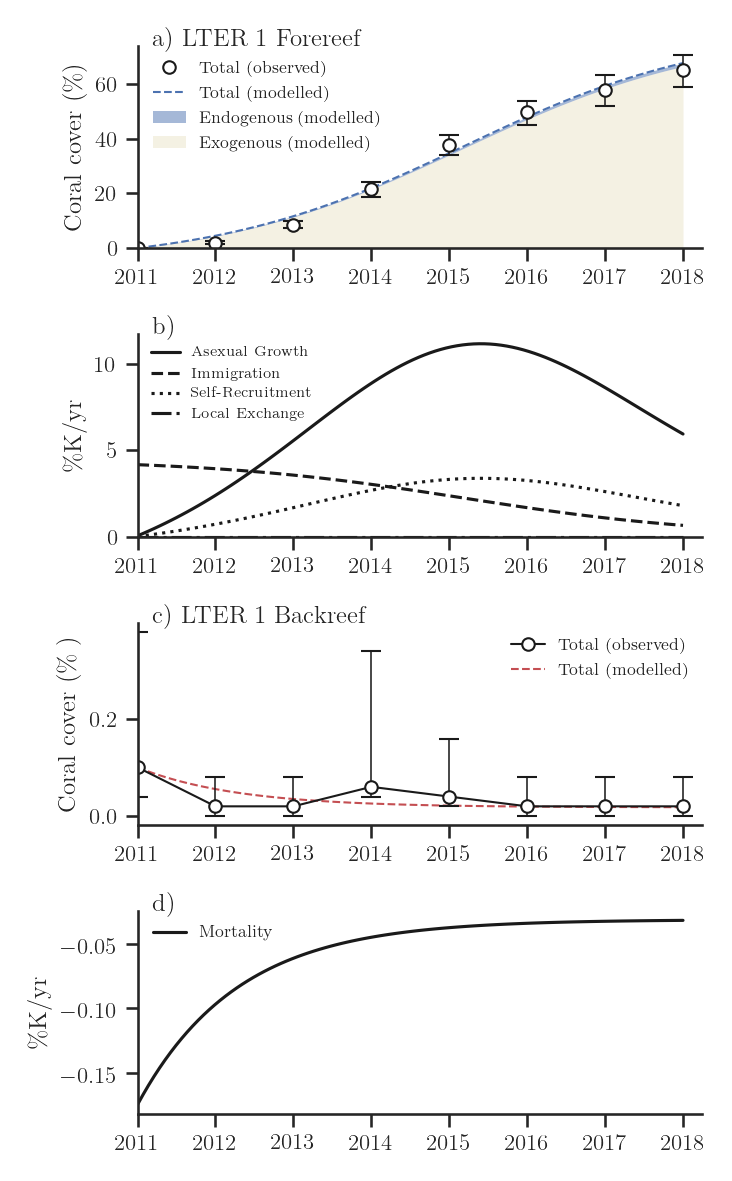

In [346]:
plt.close("all")

fig,ax = plt.subplots(4,1,squeeze = False, figsize =  (124*mm, 200*mm))

ax[0,0].errorbar(lter.tobs, lter.bootci["forereef"]["mean"].values, yerr = np.flipud(ci_fr), capsize = 5, fmt = "ko", linewidth = 0.75, markersize = 0, zorder = 0)
ax[2,0].errorbar(lter.tobs, lter.bootci["backreef"]["mean"].values, yerr = np.flipud(ci_br), capsize = 5, fmt = "ko", linewidth = 0.75, markersize = 0, zorder = 0)

ax[0,0].plot(lter.tobs, 100*lter.meancover["forereef"].values, "ko ", linewidth = 1, markersize = 6, markeredgewidth = 1, markerfacecolor = [1,1,1,1.0], label = "Total (observed)", zorder = 0 )
ax[2,0].plot(lter.tobs, 100*lter.meancover["backreef"].values, "ko-", linewidth = 1, markersize = 6, markeredgewidth = 1, markerfacecolor = [1,1,1,1.0], label = "Total (observed)", zorder = 0)

df["Backreef Total"].plot(linestyle = "--", color = "r", ax = ax[2,0], linewidth = 1, label = "Total (modelled)", zorder = -1)
df["Forereef Total"].plot(linestyle = "--", color = "b", ax = ax[0,0], linewidth = 1, label = "Total (modelled)", zorder = -1)

ax[0,0].fill_between(lter.tsim, df["Forereef Exogenous"].values, df["Forereef Total"].values, color = "b",  label = "Endogenous (modelled)", alpha = 0.5, linewidth = 0.0, zorder = -1)
ax[0,0].fill_between(lter.tsim, df["Forereef Exogenous"].values, color = "y", alpha = 0.2, linewidth = 0.0, label = "Exogenous (modelled)", zorder = -1)

#Diagnostic Terms

ax[1,0].plot(lter.tsim, D.asexual[:,1]*100/lter.k[1],          label =  "Asexual Growth", color = "k", linestyle = "-")
ax[1,0].plot(lter.tsim, D.immigration[:,1]*100/lter.k[1],      label = "Immigration", color = "k", linestyle = "--")
ax[1,0].plot(lter.tsim, D.self_recruitment[:,1]*100/lter.k[1], label = "Self-Recruitment", color = "k", linestyle = "dotted")
ax[1,0].plot(lter.tsim, D.local_exchange[:,1]*100/lter.k[1],   label = "Local Exchange", color = "k", linestyle = "-.")

ax[-1,0].plot(lter.tsim, D.asexual[:,0]*100/lter.k[0],          label = "Mortality", color = "k", linestyle = "-")
#ax[-1,0].plot(lter.tsim, D.immigration[:,0]*100/lter.k[0],      label = "Immigration", color = "k", linestyle = "--")
#ax[-1,0].plot(lter.tsim, D.self_recruitment[:,0]*100/lter.k[0], label = "Self-Recruitment", color = "k", linestyle = "dotted")
#ax[-1,0].plot(lter.tsim, D.local_exchange[:,0]*100/lter.k[0],   label = "Local Exchange", color = "k", linestyle = "-.")

#Plot attributes

ax[0,0].legend(frameon=False, fontsize = 8)
ax[0,0].set_ylim(0,None)
ax[0,0].set_ylabel(r" Coral cover (\%)")

ax[2,0].legend(frameon=False, fontsize = 8)
ax[2,0].set_ylabel(r" Coral cover (\% )");

ax[1,0].set_ylabel(r"\%K/yr")
ax[1,0].set_xlim([2011,2018])
ax[1,0].set_ylim([0,None])
ax[1,0].legend(frameon = False, fontsize = 7)

ax[-1,0].set_ylabel(r"\%K/yr")
ax[-1,0].legend(frameon = False, fontsize = 8)

labels = ["a) LTER 1 Forereef", "b)", "c) LTER 1 Backreef", "d)"]
for axis,l in zip(ax.flat, labels):
    axis.annotate( f"{l}", (0.025, 1.0), xycoords = "axes fraction" )
    axis.set_xlim(2011.0 , 2018.25)

sns.despine(fig)
# fig.subplots_adjust(wspace = 0.275, hspace = 0.5)
fig.tight_layout()

Looks pretty good! Next we will use Monte-Carlo simulations of randomly sampled data to generate a range of model hindcasts for both sites.

# Monte Carlo Simulation

Here we will generate an array of hindcasts and save the model parameters to a netcdf file. _xarray_ will help organize the data structure, assign useful attributes, and write to .nc. Skip ahead to the next section if the files have already been written to output ("lter1.nc", "lter2.nc")

In [348]:
nmc = 100 #number of monte-carlo simulations

source = ["backreef", "forereef"]
destin = ["backreef", "forereef"]
site   = ["backreef", "forereef"]
origin = ["endogenous", "exogenous"]
diagnostic = ["asexual", "immigration", "self recruitment", "local exchange"]
time =   lter.tsim
hindcast = np.arange(nmc)

coords = dict( site = site,
               origin = origin,
               time = time,
               hindcast = hindcast, 
               source = source, 
               destin = destin,
               diagnostic = diagnostic)

dims = ["site", "time", "hindcast", "source", "destin", "origin"]

population = xr.DataArray(coords = dict(hindcast = hindcast, site = site, origin = origin, time = time ), 
                          dims = ["hindcast", "site", "origin", "time" ] )
dpdt = xr.DataArray(coords = dict(hindcast = hindcast, site = site, time = time, diagnostic = diagnostic), dims = ["hindcast", "site", "time", "diagnostic" ] )

# dpdt_asexual = xr.DataArray(coords = dict(hindcast = hindcast, site = site, time = time ), dims = ["hindcast", "site", "time" ] )
# dpdt_immigration = xr.DataArray(coords = dict(hindcast = hindcast, site = site, time = time ), dims = ["hindcast", "site", "time" ] )
# dpdt_self_recruitment = xr.DataArray(coords = dict(hindcast = hindcast, site = site, time = time ), dims = ["hindcast", "site", "time" ] )
# dpdt_local_exchange = xr.DataArray(coords = dict(hindcast = hindcast, site = site, time = time ), dims = ["hindcast", "site", "time" ] )

stat = xr.DataArray( coords = dict(hindcast = hindcast),
                    dims = ["hindcast"] )
C  = xr.DataArray(  coords = dict(hindcast = hindcast, source = source, destin = destin), 
                    dims = ["hindcast", "source", "destin"] )
I =  xr.DataArray(  coords = dict(hindcast = hindcast, site = site),
                    dims = ["hindcast", "site"] )
r =  xr.DataArray(  coords = dict(hindcast = hindcast, site = site),
                    dims = ["hindcast", "site"] )
f = xr.DataArray(lter.f)
sigma =  xr.DataArray(lter.sigma)

attrs = dict( f     = "fecundity (# larvae/polyp)",
              sigma = "polyps/recruit",
              C     = "Connectivity matrix. Diagonal elements include contribution from asexual growth",
              I     = "Immigrants in polyps/yr",
              r     = "asexual growth/mortality rate yr^-1",
              population = "pocillopora population in terms of % coral cover",
              dpdt = "change in population (%K/yr)"
            )

                
data_vars = dict( population = population,
                  dpdt = dpdt,
                  stat = stat, 
                  C = C,
                  I = I,
                  r = r,
                  f = f,
                  sigma = sigma)

ds = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)
#ds

In [349]:
#Random sample within bootstrap CI
from IPython.display import clear_output

br = lter.bootci["backreef"]/100*lter.area[0]*lter.polypdensity #convert to polyps
fr = lter.bootci["forereef"]/100*lter.area[1]*lter.polypdensity #convert to polyps

#display(f"Monte-Carlo simulation of {lter.name}...")

q = 0
while q < ds.hindcast.values[-1]:
    
    br["rand"] = np.random.uniform( br["hi"], br["lo"] ) #draw random sample, 
    fr["rand"] = np.random.uniform( fr["hi"], fr["lo"] ) #draw random sample, 
    p0 = np.array([br["rand"].iloc[0], fr["rand"].iloc[0]]) #initial conditions
    p0 = np.append(p0, (0,0)) #initialize exogeneous population as 0
    
    m = differential_evolution(R2, bounds = bounds, args = (lter, br["rand"].values, fr["rand"].values,), 
                               disp = False, workers = 1, mutation = .75, recombination = 0.75, updating = "deferred")
    
    #only proceed append data if optimization successful and mean R2 > 0.95
    r2 = 1 - m.fun
    
    if m.success and (r2 > 0.95):
        
        #Assign skill fit value
        
        ds["stat"][hindcast == q] = r2
        
        #Recover solution 
        
        C, I = x2ci(m.x) #fetch (C,I) fit
        args = tuple( [lter.k, lter.f, lter.sigma, C, I] )
        sol = odeint(coral_ode_dia, p0, lter.tsim, args = args)  #solve ODE
        df = sol2df(sol,lter) #convert to dataframe

        sol_total = np.squeeze( np.array( [ lter.cover2polyp(df["Backreef Total"].values, lter.area[0]), 
                                            lter.cover2polyp(df["Forereef Total"].values, lter.area[1])] ) )
        
        #Separate growth rate and self recruitment
        
        #rho = res.confidence_interval.low*4*lter.area[1]*lter.sigma
        rho = res.confidence_interval.high*4*lter.area[1]*lter.sigma
        #rho = res.bootstrap_distribution.mean()*4*lter.area[1]*lter.sigma
        
        cii = recruit2cii(t = df.index.values, 
                          pi = lter.cover2polyp( df["Forereef Total"].values, area = lter.area[1]),
                          pj = lter.cover2polyp( df["Backreef Total"].values, area = lter.area[0]), 
                          rho = rho, Cji = C[1,0], I = I[1], k = lter.k[1], year = 2014 )
        
        #Assign connectivity matrix
        
        cff = lter.f*lter.sigma
        ds["C"].loc[dict(hindcast = q, source = "backreef", destin = "backreef")] = cii[0]/cff #convert to units of off diagonal terms
        ds["C"].loc[dict(hindcast = q, source = "forereef", destin = "forereef")] = cii[1]/cff #convert to units of off diagonal terms
        ds["C"].loc[dict(hindcast = q, source = "forereef", destin = "backreef")] = C[0,1]
        ds["C"].loc[dict(hindcast = q, source = "backreef", destin = "forereef")] = C[1,0]
        
        #Assign immigration
        
        ds["I"].loc[dict(hindcast = q, site = "backreef")] = I[0]
        ds["I"].loc[dict(hindcast = q, site = "forereef")] = I[1]
    
        #Assign asexual growth/mortality rate
        
        r = [ C[0,0], C[1,1] - cii[1] ]
        ds["r"].loc[dict(hindcast = q, site = "backreef")] = r[0]
        ds["r"].loc[dict(hindcast = q, site = "forereef")] = r[1]
        
        #Assign population vs. time by origin and site
        
        ds["population"].loc[dict(hindcast = q, site = "backreef", origin = "endogenous")] = df["Backreef Endogenous"].values
        ds["population"].loc[dict(hindcast = q, site = "forereef", origin = "endogenous")] = df["Forereef Endogenous"].values
        ds["population"].loc[dict(hindcast = q, site = "backreef", origin = "exogenous" )] = df["Backreef Exogenous"].values
        ds["population"].loc[dict(hindcast = q, site = "forereef", origin = "exogenous" )] = df["Forereef Exogenous"].values
        
        #Compute and assign population growth diagnostics in %K/yr
       
        D = dpdt_diagnostic(sol_total, n = lter.n, k = lter.k, C = C, I = I, cii = cii)
        
        #Forereef
        cff = 100/lter.k[1]
        ds["dpdt"].loc[dict(hindcast = q, site = "forereef", diagnostic = "asexual")] = D.asexual[:,1]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "forereef", diagnostic = "self recruitment")] = D.self_recruitment[:,1]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "forereef", diagnostic = "immigration")] = D.immigration[:,1]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "forereef", diagnostic = "local exchange")] = D.local_exchange[:,1]*cff
        
        #Backreef
        cff = 100/lter.k[0]
        ds["dpdt"].loc[dict(hindcast = q, site = "backreef", diagnostic = "asexual")] = D.asexual[:,0]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "backreef", diagnostic = "self recruitment")] = D.self_recruitment[:,0]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "backreef", diagnostic = "immigration")] = D.immigration[:,0]*cff
        ds["dpdt"].loc[dict(hindcast = q, site = "backreef", diagnostic = "local exchange")] = D.local_exchange[:,0]*cff
    
        q += 1
        display(f"{q+1}/{nmc} hindcasts completed.")
        clear_output(wait = True)


KeyboardInterrupt



In [109]:
ds.to_netcdf("lter1.nc")
#permission issues just means file already exists

## Start here if hindcasts already complete

Read in ("lter1.nc", "lter2.nc")

In [352]:
ds1 = xr.open_dataset("lter1.nc")
ds2 = xr.open_dataset("lter2.nc")

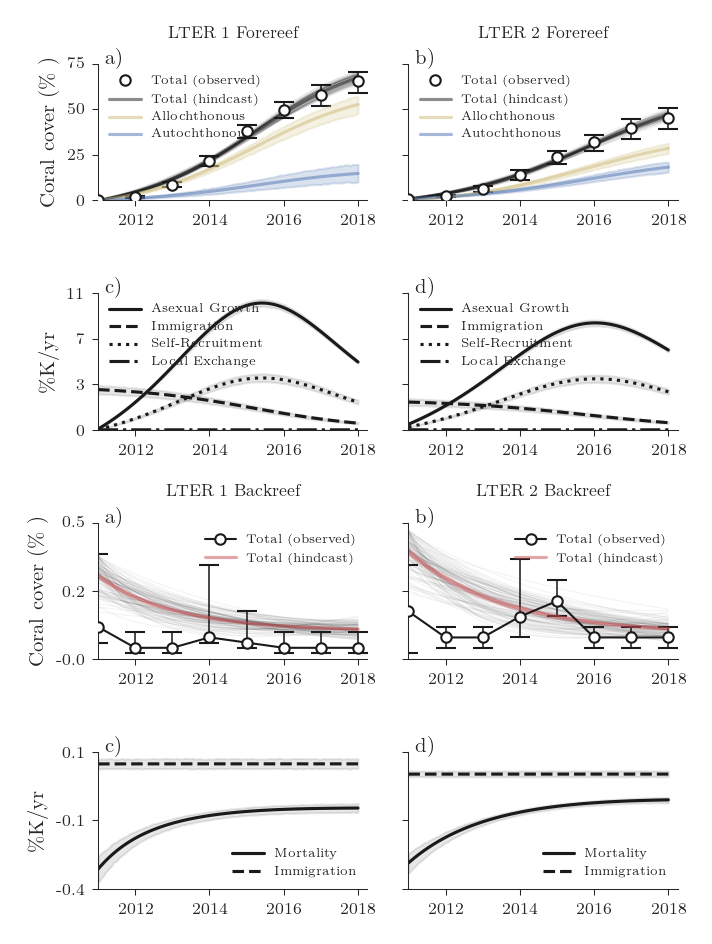

In [353]:
#Plot Monte-Carlo Simulations
import matplotlib.ticker as ticker

width = (131+0.2+1/30)*mm
# width = 174*mm
width = 129*mm

plt.close("all")

#fig,ax = plt.subplots(4,2, squeeze = False, figsize =  (width, 160*mm), sharex = False, sharey = "row")
fig,ax = plt.subplots(4,2, squeeze = False, figsize =  (4.75, 160*mm), sharex = False, sharey = "row")


for k,(ds,lter) in enumerate( zip([ds1,ds2],[LTER1,LTER2]) ):
    
    #Compute population totals

    total_fr = ds.population.sel(site = "forereef").sel(origin = "endogenous") + ds.population.sel(site = "forereef").sel(origin = "exogenous")
    total_br = ds.population.sel(site = "backreef").sel(origin = "endogenous") + ds.population.sel(site = "backreef").sel(origin = "exogenous")

    #arrange endogenous/exogenous population back into dataframe format for sns.lineplot method

    df_tot_fr = total_fr.to_dataframe()
    df_tot_br = total_br.to_dataframe()

    df_endo = ds.sel(site="forereef", origin = "endogenous").population.to_dataframe()
    df_exo  = ds.sel(site="forereef", origin = "exogenous" ).population.to_dataframe()

    df_dpdt_fr = ds.sel(site = "forereef").dpdt.to_dataframe()
    df_dpdt_br = ds.sel(site = "backreef").dpdt.to_dataframe()

    #Plot Observations

    ax[0,k].errorbar(lter.tobs, lter.bootci["forereef"]["mean"].values, yerr = np.flipud(ci_fr), capsize = 5, fmt = "ko", linewidth = 0.75, markersize = 0, zorder = 0)
    ax[2,k].errorbar(lter.tobs, lter.bootci["backreef"]["mean"].values, yerr = np.flipud(ci_br), capsize = 5, fmt = "ko", linewidth = 0.75, markersize = 0, zorder = 0)

    ax[0,k].plot(lter.tobs, 100*lter.meancover["forereef"].values, "ko ", linewidth = 1, markersize = 5, markeredgewidth = 1, markerfacecolor = [1,1,1,1.0], label = "Total (observed)", zorder = 10)
    ax[2,k].plot(lter.tobs, 100*lter.meancover["backreef"].values, "ko-", linewidth = 1, markersize = 5, markeredgewidth = 1, markerfacecolor = [1,1,1,1.0], label = "Total (observed)", zorder = 10)

    #Plot total population
    
    total_fr.plot.line(ax = ax[0,k], x = "time", color = "k", alpha = 0.05, linewidth = 1/2, add_legend = False);
    total_br.plot.line(ax = ax[2,k], x = "time", color = "k", alpha = 0.05, linewidth = 1/2, add_legend = False);

    #PLot simulated population

    sns.lineplot(ax = ax[0,k], data = df_tot_fr , x = "time", y = "population", color = "k", label = "Total (hindcast)", alpha = 0.5, err_kws = dict(alpha = 0))
    sns.lineplot(ax = ax[2,k], data = df_tot_br , x = "time", y = "population", color = "r", label = "Total (hindcast)", alpha = 0.5)

    sns.lineplot(ax = ax[0,k], data = df_exo , x = "time", y = "population", color = "y", alpha = 0.5, label = "Allochthonous")
    sns.lineplot(ax = ax[0,k], data = df_endo, x = "time", y = "population", color = "b", alpha = 0.5, label = "Autochthonous")

    kwargs = dict(color = "k")
    err_kws = dict(alpha = 0.1)
    sns.lineplot(ax = ax[1,k], data = df_dpdt_fr.query(" diagnostic == 'asexual' "), x = "time", y = "dpdt", label = "Asexual Growth", linestyle = "-",  **kwargs, err_kws = err_kws)
    sns.lineplot(ax = ax[1,k], data = df_dpdt_fr.query(" diagnostic == 'immigration' "), x = "time", y = "dpdt", label = "Immigration", linestyle = "--", **kwargs, err_kws = err_kws)
    sns.lineplot(ax = ax[1,k], data = df_dpdt_fr.query(" diagnostic == 'self recruitment' "), x = "time", y = "dpdt", label = "Self-Recruitment", linestyle = "dotted", **kwargs, err_kws = err_kws)
    sns.lineplot(ax = ax[1,k], data = df_dpdt_fr.query(" diagnostic == 'local exchange' "), x = "time", y = "dpdt", label = "Local Exchange", linestyle = "-.", **kwargs, err_kws = err_kws)

    sns.lineplot(ax = ax[-1,k], data = df_dpdt_br.query(" diagnostic == 'asexual' "), x = "time", y = "dpdt", label = "Mortality", linestyle = "-",  **kwargs, err_kws = err_kws)
    sns.lineplot(ax = ax[-1,k], data = df_dpdt_br.query(" diagnostic == 'immigration' "), x = "time", y = "dpdt", label = "Immigration", linestyle = "--", **kwargs, err_kws = err_kws)
    #sns.lineplot(ax = ax[-1], data = df_dpdt_br.query(" diagnostic == 'self recruitment' "), x = "time", y = "dpdt", label = "Self-Recruitment", linestyle = "dotted", **kwargs, err_kws = err_kws)
    #sns.lineplot(ax = ax[-1],  data = df_dpdt_br.query(" diagnostic == 'local exchange' "), x = "time", y = "dpdt", label = "Local Exchange", linestyle = "-.", **kwargs, err_kws = err_kws) #weird values
    
# labels = ["a) LTER 1 Forereef", "b)", "c) LTER 1 Backreef", "d)",
#           "e) LTER 2 Forereef", "f)", "g) LTER 2 Backreef", "h)"]
labels = [" a)", "c)", "a)", "c)",
           "b)", "d)", "b)", "d)"]

for axis,l in zip(ax.flatten(order = "F"), labels):
    axis.set_title("")
    axis.annotate( f"{l}", (0.025, 1.0), xycoords = "axes fraction", fontsize = 10)
    axis.set_xlim(2011 , 2018.25)
    

title_kwargs = dict(pad = 12.5, fontsize = 8)
ax[0,0].set_title( "LTER 1 Forereef", **title_kwargs)
ax[0,1].set_title( "LTER 2 Forereef", **title_kwargs)

ax[2,0].set_title( "LTER 1 Backreef", **title_kwargs)
ax[2,1].set_title( "LTER 2 Backreef", **title_kwargs)

for axis in ax.flat[4:]:
    axis.yaxis.set_major_locator(ticker.LinearLocator(3))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    
for axis in ax.flat[:3]:
    axis.set_ylim(0,None)
    axis.yaxis.set_major_locator(ticker.LinearLocator(4))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    
for axis in ax.flat:
    axis.legend(frameon = False, fontsize = 6, handlelength=2.5)
    #axis.yaxis.set_offset_position("left")
    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.tick_params(width = 0.5, length = 3, labelsize = 8)
    plt.setp(axis.spines.values(), linewidth = 0.5)

ax[0,0].set_ylabel(r"Coral cover (\% )", fontsize = 10);
ax[2,0].set_ylabel(r"Coral cover (\% )", fontsize = 10);

ax[1,0].set_ylabel(r"\%K/yr", fontsize = 10)
ax[3,0].set_ylabel(r"\%K/yr", fontsize = 10)

# ax[-1, 0].set_xlabel(r"Year", fontsize = 10)
# ax[-1,-1].set_xlabel(r"Year", fontsize = 10)

# ax[1, 0].set_xlabel(r"Year", fontsize = 10)
# ax[1,-1].set_xlabel(r"Year", fontsize = 10)

ax[0,0].set_yticks([0,25,50,75])

sns.despine(fig)
fig.subplots_adjust(wspace = -0.05, hspace = 0.1)
fig.tight_layout()

#fig.savefig("lter.pdf", bbox_inches = "tight")#, dpi = 300)